# Setting argument

In [1]:
import argparse

# setting hyperparameters
parser = argparse.ArgumentParser(description='net')
parser.add_argument('--batchsize', '-b', 
                    type=int, 
                    default=10,
                    help='Number of images in each mini-batch')
parser.add_argument('--gpu', '-g', 
                    type=int, 
                    default=0,
                    help='GPU ID (-1 indicates CPU)')#Set the initial matrix
# create arg object
args = parser.parse_args([])

# setting state
CLASS_NUM = 2

# Load Data of LUNA16

In [2]:
from Luna16 import Luna16
import torch
import torchvision.transforms as transforms

transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.ToPILImage(),
#     transforms.RandomCrop(256),
    transforms.ToTensor()
])

testset = Luna16(csv_file='../LUNA16/CSVFILES/annotations.csv',
                 root_dir='../LUNA16/data',
                 transform=transform,
                 is_segment=True,
                 seg_size=[10,50,50])

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=args.batchsize,
                                         shuffle=True, 
                                         num_workers=6)

# To GPU

In [3]:
if(args.gpu == -1):
    device = torch.device('cpu')
else:
    device = torch.device('cuda:'+str(args.gpu) if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
torch.cuda.empty_cache()
print(device)

cuda:0


# Build net

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from pytorch_analyzer import Pytorch_Analyzer

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv3d(1, 32, kernel_size=(3,3,3), padding=1),
                        nn.LeakyReLU(),
                        nn.BatchNorm3d(32))
        self.layer2 = nn.Sequential(
                        nn.Conv3d(32, 128, kernel_size=(3,3,3), padding=1),
                        nn.LeakyReLU(),
                        nn.Conv3d(128, 64, kernel_size=(1,1,1), padding=(0,1,1)),
                        nn.LeakyReLU(),
                        nn.BatchNorm3d(32),
                        nn.Conv3d(32, 64, kernel_size=(3,3,3), padding=1),
                        nn.LeakyReLU(),
                        nn.BatchNorm3d(64))
        self.layer3 = nn.Sequential(
                        nn.Conv3d(64, 32, kernel_size=(3,3,3), padding=1),
                        nn.LeakyReLU(),
                        nn.BatchNorm3d(32))
        self.layer4 = nn.Sequential(
                        nn.Conv3d(32, CLASS_NUM, kernel_size=(3,3,3), padding=1),
                        nn.LeakyReLU(),
                        nn.Softmax(dim=1))

        
    def forward(self, x):
        out1 = self.layer1(x)
        out = self.layer2(out1)
        out = self.layer3(out)
        out = out + out1
        out = self.layer4(out)
        return out
    
net = Net().cuda()
net.eval()
net.load_state_dict(torch.load('net_parameters.pkl'))

<All keys matched successfully>

# Inference

In [5]:
import Accuracy
threshold = 0.6
TP = 0.0
FP = 0.0
TN = 0.0
FN = 0.0

for i, data in enumerate(testloader):
    # [person][data, label][channel][depth][H][W]
    inputs, labels = data['data'].cuda(), data['label']
    # forward
    outputs = net(inputs)
    # Accuracy
    for batch_idx in range(outputs.shape[0]):
        label = labels[batch_idx]
        prediction =  outputs[batch_idx].cpu()
        tp, fp, tn, fn = Accuracy.eval(prediction, label, threshold)
        TP += tp; FP += fp; TN += tn; FN += fn
    break
        
sensitivity = TP/(TP+FN) if (TP+FN)!=0 else 0
precision = TP/(TP+FP) if (TP+FP)!=0 else 0
fpr = FP/(FP+TN) if (FP+TN)!=0 else 0

print('Finished Inference')

Finished Inference


# Accuracy

In [6]:
import pandas as pd
from IPython import display

display.display(
    pd.DataFrame({
        'True Negative Number:': [TN],
        'False Positive Number': [FP],
        'True Positive Number': [TP],
        'False Negative Number': [FN]
}))

display.display(
    pd.DataFrame({
        'Sensitivity': [sensitivity*100.],
        'Precision': [precision*100.],
        'False Positive Rate': [fpr*100.]
}))

,True Negative Number:,False Positive Number,True Positive Number,False Negative Number
0,16.0,34.0,27.0,23.0


,Sensitivity,Precision,False Positive Rate
0,54.0,44.262295,68.0


# Result

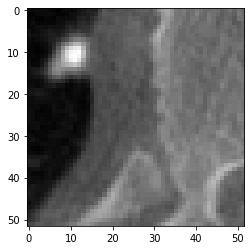

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


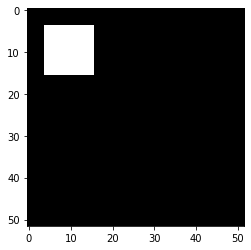

tensor([[  0,   0,   0,  ...,   0, 255, 255],
        [255,   0,   0,  ..., 255, 255, 255],
        [255,   0, 255,  ..., 255, 255, 255],
        ...,
        [255,   0, 255,  ..., 255, 255, 255],
        [255,   0,   0,  ...,   0, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]], device='cuda:0')


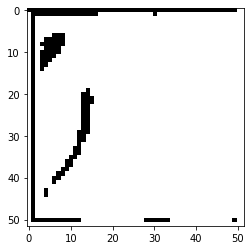

In [8]:
import matplotlib.pyplot as plt

batch = 5
depth = 8

img = inputs[batch][0][depth]
img = img.cpu()
plt.imshow(img, cmap='gray')
plt.show()

img = labels[batch][depth]
img = img.cpu()
print(img)
plt.imshow(img, cmap='gray')
plt.show()

img = outputs[batch][1][depth]
img = (img > threshold) * 255
print(img)
img = img.cpu()
plt.imshow(img, cmap='gray')
plt.show()

# FROC

import numpy as np
label = labels[batch].to(torch.device('cpu'))
prediction = outputs[batch][0].to(torch.device('cpu'))

Sensitivity_list = []
False_Positive_Rate_list = []

for threshold in np.arange(3.8, 5, 0.001):
    TP, FP, TN, FN = Accuracy.eval(prediction, label, threshold)
    Sensitivity_list.append(TP/(TP+FN))
    False_Positive_Rate_list.append(FP/(FP+TN))

plt.plot(False_Positive_Rate_list, Sensitivity_list)
plt.title('FROC')
plt.xlabel('FPs')
plt.ylabel('Sensitivity')
plt.show()